<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>
In The Name of God
</font>
<br>
<img src="https://logoyar.com/content/wp-content/uploads/2021/04/sharif-university-logo.png" alt="University Logo" width="150" height="150">
<br>
<font face="Times New Roman" size=4 align=center>
Sharif University of Technology - Department of Electrical Engineering
</font>
<br>
<font color="#008080" size=6>
Deep Generative Models
</font>

<hr/>
<font color="#800080" size=5>
Assignment 3: Generative Adversarial Networks
<br>
</font>
<font size=5>
Instructor: Dr. S. Amini
<br>
</font>
<font size=4>
Fall 2024
<br>
</font>
<font face="Times New Roman" size=4>
Deadline: Month day at 23:55
</font>
<hr>
</div></font>

In [ ]:
name = 'Fatemeh Raeijian'
std_id = '402203389'

### In this notebook, you will implement the required components from scratch, without code completion. Utilize `torch` to create models and perform optimization. The goal of this assignment is to implement Deep Convolutional Generative Adversarial Networks (DC-GAN) using the MNIST dataset and to explore interpolation in the latent space.

### To get started, please read the DC-GAN paper available at this link: [DC-GAN Paper](https://arxiv.org/abs/1511.06434v2).


### Part 1. Load the MNIST dataset.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import os

manualSeed = 999
torch.manual_seed(manualSeed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 128
image_size = 28
nc = 1  
nz = 100 
ngf = 64  
ndf = 64
num_epochs = 50
lr = 0.0002
beta1 = 0.5

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:12<00:00, 763732.42it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 176663.25it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:03<00:00, 519563.72it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5441453.52it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Part 2: Build the Generator and Discriminator models.
Build the models with the architecture guidelines for stable training as described in the paper. It is recommended to use the model parameters presented in `config.yaml`, but you are free to choose any set of parameters you prefer.


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import os

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 4, kernel_size=4, stride=1, padding=0, bias=False),  
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=3, stride=2, padding=1, bias=False),  
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),  
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf, nc, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.Tanh(),
            
            nn.Upsample(size=(28, 28), mode='bilinear', align_corners=True)
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False),  
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),  
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 2, ndf * 4, kernel_size=3, stride=2, padding=0, bias=False),  
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Flatten(),
            nn.Linear(ndf * 4 * 3 * 3, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 128
image_size = 28
nc = 1  
nz = 100  
ngf = 64  
ndf = 64  
num_epochs = 50
lr = 0.0002
beta1 = 0.5

netG = Generator(nz, ngf, nc).to(device)
netG.apply(weights_init)
print(netG)

netD = Discriminator(nc, ndf).to(device)
netD.apply(weights_init)
print(netD)


Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
    (11): Upsample(size=(28, 28), mode='bilinear')
  )
)
Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplac

### Part 3: Write a function to train the models using the GAN framework.
You can refer to the slides or the original GAN paper for the training schema: [GAN Paper](https://arxiv.org/abs/1406.2661). Additionally, create a function to generate samples from the model. Ensure to plot a grid of generated samples every n'th epoch.


In [18]:

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

criterion = nn.BCELoss()

fixed_noise = torch.randn(100, nz, 1, 1, device=device)

real_label = 1.
fake_label = 0.

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

def save_generated_images(epoch, fixed_noise, netG, device, output_dir='output_images'):
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    grid = vutils.make_grid(fake, padding=2, normalize=True, nrow=10)
    os.makedirs(output_dir, exist_ok=True)
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title(f"Generated Images at Epoch {epoch}")
    plt.imshow(np.transpose(grid, (1,2,0)))
    plt.savefig(f"{output_dir}/epoch_{epoch}.png")
    plt.close()

G_losses = []
D_losses = []
img_list = []

print("Starting Training Loop...")
for epoch in range(1, num_epochs+1):
    for i, (data, _) in enumerate(dataloader, 1):
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        netD.zero_grad()
        real_data = data.to(device)
        b_size = real_data.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_data).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        
        if epoch == 1 and i == 1:
            print(f"Fake images shape: {fake.shape}")  
            print(f"Real data shape: {real_data.shape}")  
        
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # (2) Update G network: maximize log(D(G(z)))
        netG.zero_grad()
        label.fill_(real_label)  
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if i % 100 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}] '
                  f'Loss_D: {errD.item():.4f} '
                  f'Loss_G: {errG.item():.4f} '
                  f'D(x): {D_x:.4f} '
                  f'D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')

    if epoch % 5 == 0 or epoch == 1:
        save_generated_images(epoch, fixed_noise, netG, device)


Starting Training Loop...


Fake images shape: torch.Size([128, 1, 28, 28])
Real data shape: torch.Size([128, 1, 28, 28])
[1/50][100/469] Loss_D: 1.1613 Loss_G: 5.6052 D(x): 0.9822 D(G(z)): 0.5896 / 0.0053
[1/50][200/469] Loss_D: 0.2936 Loss_G: 3.4105 D(x): 0.7797 D(G(z)): 0.0300 / 0.0398
[1/50][300/469] Loss_D: 2.5950 Loss_G: 2.5109 D(x): 0.1138 D(G(z)): 0.0088 / 0.1072
[1/50][400/469] Loss_D: 0.1463 Loss_G: 3.0483 D(x): 0.9393 D(G(z)): 0.0768 / 0.0576
[2/50][100/469] Loss_D: 0.1738 Loss_G: 2.5416 D(x): 0.8899 D(G(z)): 0.0460 / 0.1092
[2/50][200/469] Loss_D: 1.5711 Loss_G: 0.6541 D(x): 0.2693 D(G(z)): 0.0048 / 0.5624
[2/50][300/469] Loss_D: 0.3384 Loss_G: 2.0526 D(x): 0.8203 D(G(z)): 0.1167 / 0.1578
[2/50][400/469] Loss_D: 0.5705 Loss_G: 1.4835 D(x): 0.7097 D(G(z)): 0.1761 / 0.2555
[3/50][100/469] Loss_D: 0.6034 Loss_G: 1.2000 D(x): 0.6065 D(G(z)): 0.0459 / 0.3419
[3/50][200/469] Loss_D: 0.4414 Loss_G: 2.7452 D(x): 0.8987 D(G(z)): 0.2622 / 0.0795
[3/50][300/469] Loss_D: 0.7265 Loss_G: 1.1623 D(x): 0.6738 D(G(z))

### Part 4: Plot a grid of 100 generated samples.

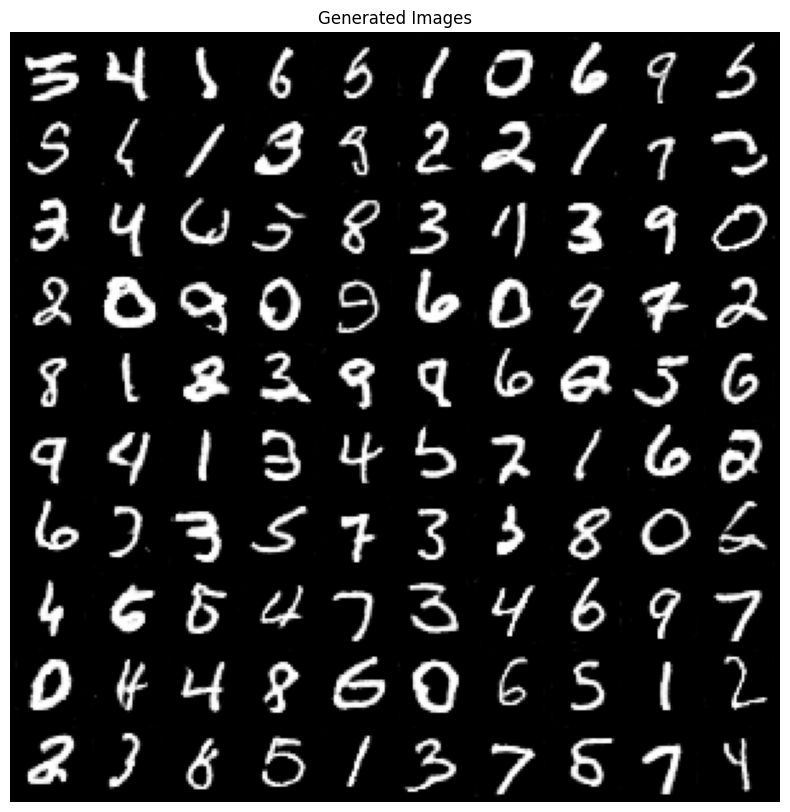

In [19]:
def display_generated_images(netG, device, nz, num_images=100, nrow=10, output_dir='output_images'):
    with torch.no_grad():
        noise = torch.randn(num_images, nz, 1, 1, device=device)
        fake_images = netG(noise).detach().cpu()
    grid = vutils.make_grid(fake_images, nrow=nrow, normalize=True)
    plt.figure(figsize=(10,10))
    plt.axis("off")
    plt.title("Generated Images")
    plt.imshow(np.transpose(grid, (1,2,0)))
    plt.show()

display_generated_images(netG, device, nz)


### Part 5: GAN Inversion
In this part, we aim to find the latent vectors corresponding to the samples in the dataset. First, select a random sample from the real dataset and a random latent vector. Freeze the generator and feed the random latent vector into the Generator. Next, define an MSE or MAE loss between the generated sample and the real sample, and optimize the random latent vector to discover the latent vector that generates the selected real sample.


Step 1/1000, Loss: 0.511754
Step 100/1000, Loss: 0.035421
Step 200/1000, Loss: 0.017928
Step 300/1000, Loss: 0.011968
Step 400/1000, Loss: 0.010342
Step 500/1000, Loss: 0.008983
Step 600/1000, Loss: 0.008206
Step 700/1000, Loss: 0.007754
Step 800/1000, Loss: 0.007438
Step 900/1000, Loss: 0.007182
Step 1000/1000, Loss: 0.007013


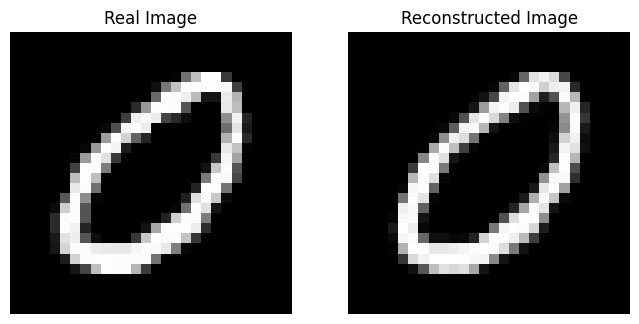

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

def gan_inversion(netG, real_image, device, nz, num_steps=1000, lr=0.01):
    
    z = torch.randn(1, nz, 1, 1, device=device, requires_grad=True)
    optimizer = optim.Adam([z], lr=lr)
    criterion = nn.MSELoss()

    netG.eval()

    real_image = real_image.to(device)

    for step in range(1, num_steps + 1):
        optimizer.zero_grad()
        fake_image = netG(z)
        loss = criterion(fake_image, real_image)
        loss.backward()
        optimizer.step()

        if step % 100 == 0 or step == 1:
            print(f'Step {step}/{num_steps}, Loss: {loss.item():.6f}')

    return z.detach()

def plot_real_and_reconstructed(real, reconstructed):
    real = real.squeeze(0)  
    reconstructed = reconstructed.squeeze(0)  
    
    if real.dim() == 3 and real.size(0) == 1:
        real = real.squeeze(0)
    if reconstructed.dim() == 3 and reconstructed.size(0) == 1:
        reconstructed = reconstructed.squeeze(0)
    
    real = real.cpu().numpy()
    reconstructed = reconstructed.cpu().numpy()
    
    real = (real * 0.5) + 0.5
    reconstructed = (reconstructed * 0.5) + 0.5

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    
    axs[0].imshow(real, cmap='gray')
    axs[0].set_title("Real Image")
    axs[0].axis('off')
    
    axs[1].imshow(reconstructed, cmap='gray')
    axs[1].set_title("Reconstructed Image")
    axs[1].axis('off')
    
    plt.show()

dataiter = iter(dataloader)
try:
    real_batch, _ = next(dataiter)
except StopIteration:
    print("The DataLoader is empty. Please check your dataset and DataLoader configuration.")
    real_batch, _ = next(iter(dataloader)) 

real_image = real_batch[0].unsqueeze(0)  

optimized_z = gan_inversion(netG, real_image, device, nz, num_steps=1000, lr=0.01)

with torch.no_grad():
    reconstructed_image = netG(optimized_z).cpu()

plot_real_and_reconstructed(real_image, reconstructed_image)


### Part 6: Interpolating the Latent Space
In this part, you will interpolate the latent space using a 10 by 10 grid. Start with 4 initial points representing the corners of the square, and then perform linear or spherical interpolation between the latent vectors of these 4 images to fill the circumference of the square.
Next, fill in the rest of the square by interpolating between the latent vectors along the circumference.

If $G$ is the generator, and $z_1$ and $z_2$ are two latent vectors of two images, let $w$ be a parameter that varies between $0$ and $1$. The linearly interpolated sample is generated as:

\begin{equation}
G(w \cdot z_1 + (1 - w) \cdot z_2)\
\end{equation}

Try to select the 4 starting images from those that exhibit distinct features. For example, the two top right corners could be the same digit but one with a thick stroke and the other with a thin stroke, while the other two points should be from a different digit but with varying stroke styles.

Step 1/500, Loss: 0.599351
Step 100/500, Loss: 0.417129
Step 200/500, Loss: 0.086352
Step 300/500, Loss: 0.022638
Step 400/500, Loss: 0.012970
Step 500/500, Loss: 0.011283
Step 1/500, Loss: 0.618234
Step 100/500, Loss: 0.328164
Step 200/500, Loss: 0.291347
Step 300/500, Loss: 0.266754
Step 400/500, Loss: 0.189343
Step 500/500, Loss: 0.050399
Step 1/500, Loss: 0.401172
Step 100/500, Loss: 0.149139
Step 200/500, Loss: 0.074005
Step 300/500, Loss: 0.054119
Step 400/500, Loss: 0.047750
Step 500/500, Loss: 0.042594
Step 1/500, Loss: 0.761689
Step 100/500, Loss: 0.340382
Step 200/500, Loss: 0.177367
Step 300/500, Loss: 0.154835
Step 400/500, Loss: 0.129360
Step 500/500, Loss: 0.095081


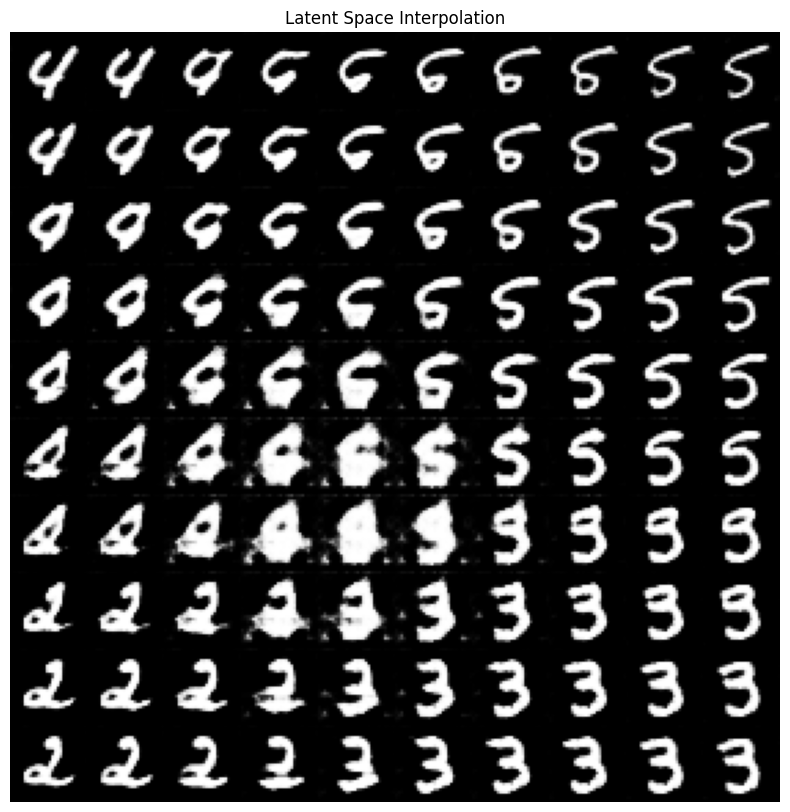

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

def interpolate(z1, z2, steps=10):
    alphas = torch.linspace(0, 1, steps).to(z1.device)
    interpolated_z = []
    for alpha in alphas:
        z = (1 - alpha) * z1 + alpha * z2
        interpolated_z.append(z)
    return interpolated_z

def select_initial_latent_vectors(netG, dataloader, device, nz, num_vectors=4):
    netG.eval()
    latent_vectors = []
    for i in range(num_vectors):
        try:
            real_batch, _ = next(iter(dataloader))
        except StopIteration:
            print("The DataLoader is empty. Please check your dataset and DataLoader configuration.")
            break
        real_image = real_batch[0].unsqueeze(0)  
        z = gan_inversion(netG, real_image, device, nz, num_steps=500, lr=0.01)
        latent_vectors.append(z)
    return latent_vectors

def gan_inversion(netG, real_image, device, nz, num_steps=1000, lr=0.01):
    z = torch.randn(1, nz, 1, 1, device=device, requires_grad=True)
    optimizer = optim.Adam([z], lr=lr)
    criterion = nn.MSELoss()

    netG.eval() 

    real_image = real_image.to(device)

    for step in range(1, num_steps + 1):
        optimizer.zero_grad()
        fake_image = netG(z)
        loss = criterion(fake_image, real_image)
        loss.backward()
        optimizer.step()

        if step % 100 == 0 or step == 1:
            print(f'Step {step}/{num_steps}, Loss: {loss.item():.6f}')

    return z.detach()

def plot_real_and_reconstructed(real, reconstructed):
    real = real.squeeze(0)  
    reconstructed = reconstructed.squeeze(0)  
    
    if real.dim() == 3 and real.size(0) == 1:
        real = real.squeeze(0)
    if reconstructed.dim() == 3 and reconstructed.size(0) == 1:
        reconstructed = reconstructed.squeeze(0)
    
    real = real.cpu().numpy()
    reconstructed = reconstructed.cpu().numpy()
    
    real = (real * 0.5) + 0.5
    reconstructed = (reconstructed * 0.5) + 0.5

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    
    axs[0].imshow(real, cmap='gray')
    axs[0].set_title("Real Image")
    axs[0].axis('off')
    
    axs[1].imshow(reconstructed, cmap='gray')
    axs[1].set_title("Reconstructed Image")
    axs[1].axis('off')
    
    plt.show()

initial_z = select_initial_latent_vectors(netG, dataloader, device, nz, num_vectors=4)

if len(initial_z) < 4:
    raise ValueError("Could not obtain 4 latent vectors. Ensure that the DataLoader has enough data.")

grid_size = 10

pairs = [
    (initial_z[0], initial_z[1]),  
    (initial_z[1], initial_z[2]),  
    (initial_z[2], initial_z[3]),  
    (initial_z[3], initial_z[0]),  
]

edge_latents = []
for (z_start, z_end) in pairs:
    interpolated = interpolate(z_start, z_end, steps=grid_size)
    edge_latents.append(interpolated)

grid_latents = []
for i in range(grid_size):
    alpha = i / (grid_size - 1)  
    row = []
    for j in range(grid_size):
        beta = j / (grid_size - 1)  
        
        z_top = edge_latents[0][j]
        z_bottom = edge_latents[2][j]
        
        z = (1 - alpha) * z_top + alpha * z_bottom
        row.append(z)
    grid_latents.append(row)

grid_images = []
with torch.no_grad():
    for row in grid_latents:
        batch_z = torch.cat(row, dim=0)  
        fake_images = netG(batch_z).cpu()
        grid_images.append(fake_images)

grid_rows = [torch.cat([img for img in batch], dim=2) for batch in grid_images]
final_grid = torch.cat(grid_rows, dim=1) 

final_grid = (final_grid + 1) / 2  

final_grid_np = final_grid.numpy().transpose(1, 2, 0)  

plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Latent Space Interpolation")
plt.imshow(final_grid_np.squeeze(), cmap='gray')
plt.show()


### Part 7: Arithmetic Operation in Latent Space
In this part, you will attempt to modify the thickness or thinness of a sample by identifying the direction in the latent space that corresponds to these attributes. Additionally, you can explore changing a digit to another (e.g., transforming a digit into a 3) by finding the direction in the latent space that corresponds to that digit.


Optimizing latent vector for thick stroke...
Step 1/500, Loss: 0.573773
Step 100/500, Loss: 0.428551
Step 200/500, Loss: 0.249749
Step 300/500, Loss: 0.120609
Step 400/500, Loss: 0.096177
Step 500/500, Loss: 0.081949
Optimizing latent vector for thin stroke...
Step 1/500, Loss: 0.597242
Step 100/500, Loss: 0.405491
Step 200/500, Loss: 0.242651
Step 300/500, Loss: 0.047868
Step 400/500, Loss: 0.043635
Step 500/500, Loss: 0.040671


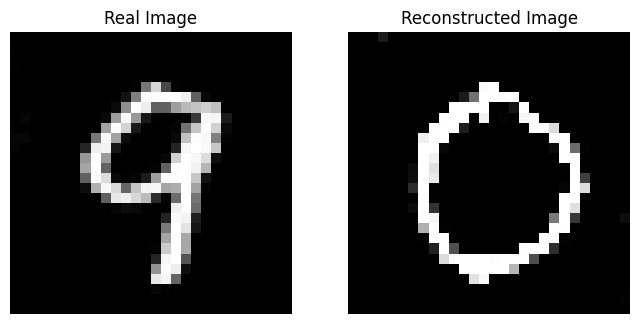

Optimizing latent vector for digit 3...
Step 1/500, Loss: 0.453525
Step 100/500, Loss: 0.052515
Step 200/500, Loss: 0.040751
Step 300/500, Loss: 0.028589
Step 400/500, Loss: 0.024460
Step 500/500, Loss: 0.022114


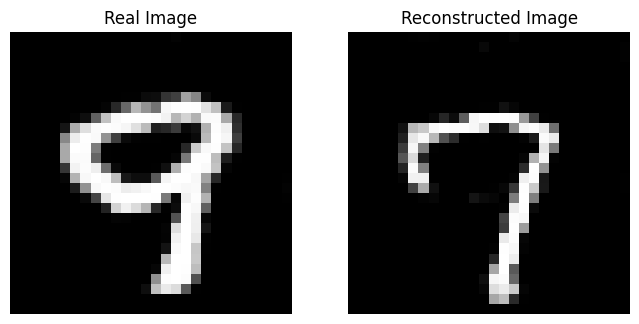

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

def plot_real_and_reconstructed(real, reconstructed):
    real = real.squeeze(0)  
    reconstructed = reconstructed.squeeze(0)  
    
    if real.dim() == 3 and real.size(0) == 1:
        real = real.squeeze(0)
    if reconstructed.dim() == 3 and reconstructed.size(0) == 1:
        reconstructed = reconstructed.squeeze(0)
    
    real = real.cpu().numpy()
    reconstructed = reconstructed.cpu().numpy()
    
    real = (real * 0.5) + 0.5
    reconstructed = (reconstructed * 0.5) + 0.5

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    
    axs[0].imshow(real, cmap='gray')
    axs[0].set_title("Real Image")
    axs[0].axis('off')
    
    axs[1].imshow(reconstructed, cmap='gray')
    axs[1].set_title("Reconstructed Image")
    axs[1].axis('off')
    
    plt.show()

def modify_attribute(netG, device, nz, direction_vector, magnitude=1.0):
    with torch.no_grad():
        z = torch.randn(1, nz, 1, 1, device=device)
        original_image = netG(z).cpu()

        modified_z = z + magnitude * direction_vector
        modified_image = netG(modified_z).cpu()

    plot_real_and_reconstructed(original_image, modified_image)

def get_direction_vector(netG, dataloader, device, nz, num_steps=500, lr=0.01):
    print("Optimizing latent vector for thick stroke...")
    try:
        real_batch, _ = next(iter(dataloader))
    except StopIteration:
        raise ValueError("The DataLoader is empty. Please check your dataset and DataLoader configuration.")
    real_image_thick = real_batch[0].unsqueeze(0).to(device)
    z_thick = gan_inversion(netG, real_image_thick, device, nz, num_steps=num_steps, lr=lr)

    print("Optimizing latent vector for thin stroke...")
    try:
        real_batch, _ = next(iter(dataloader))
    except StopIteration:
        raise ValueError("The DataLoader does not have enough data. Please check your DataLoader configuration.")
    real_image_thin = real_batch[0].unsqueeze(0).to(device)
    z_thin = gan_inversion(netG, real_image_thin, device, nz, num_steps=num_steps, lr=lr)

    direction = z_thin - z_thick
    return direction

def change_digit(netG, dataloader, device, nz, target_digit=3, num_steps=500, lr=0.01):
    for real_batch, labels in dataloader:
        if target_digit in labels:
            idx = (labels == target_digit).nonzero(as_tuple=False)[0].item()
            real_image = real_batch[idx].unsqueeze(0).to(device)
            break
    else:
        raise ValueError(f"Digit {target_digit} not found in the dataset.")

    print(f"Optimizing latent vector for digit {target_digit}...")
    z_target = gan_inversion(netG, real_image, device, nz, num_steps=num_steps, lr=lr)

    z_base = torch.randn(1, nz, 1, 1, device=device)

    direction = z_target - z_base

    modify_attribute(netG, device, nz, direction, magnitude=1.0)

direction = get_direction_vector(netG, dataloader, device, nz)

modify_attribute(netG, device, nz, direction, magnitude=5.0)

change_digit(netG, dataloader, device, nz, target_digit=3)
